In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.5 MB/s 


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor

import warnings
warnings.filterwarnings(action="ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#------------------------------------------------------------------ 학습데이터셋
from sklearn.model_selection import train_test_split

#------------------------------------------------------------------ CART(Classification and Regression Tree)
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVC, NuSVR
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor,  AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet  #----------------*****
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, confusion_matrix


#------------------------------------------------------------------ 증강학습
from sklearn.model_selection import KFold,cross_val_score,GridSearchCV
from imblearn.over_sampling import SMOTE

#------------------------------------------------------------------ 스케일링
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler


#------------------------------------------------------------------ 평가관련
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
# MAE
# MSE  : (squared=True)
# RMSE : (squared=False)
# MSLE


# 모델
from catboost import CatBoostClassifier 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier,RandomForestRegressor
from lightgbm import LGBMClassifier
from tqdm import tqdm


#------------------------------------------------------------------ 튜닝관련

import warnings
warnings.filterwarnings(action='ignore')
sns.set()

In [4]:
df= pd.read_csv('/content/drive/MyDrive/핀테크 파이널/data/real_final_data_for_modeling.csv')
# selected feature df 불러오기
feat_df = pd.read_csv('/content/drive/MyDrive/핀테크 파이널/data/feature_selection_df.csv')


# selected_x_data column 반환
def return_selected_data(df_hj, model, feature_list_name):
  df=df_hj.copy()
  for i in df.columns[1:]:
    df[i] = df[i].apply(lambda x : x[2:-2].replace("'",'').split(', '))
  tmp = df[df['model']==model][feature_list_name].iloc[0]
  return tmp
  


In [5]:
return_selected_data(feat_df,"RF",'rfe_features_list')

['총자산증가율',
 '매출액증가율',
 '총자본영업이익율',
 '총자본순이익율',
 '매출액영업이익율',
 '자기자본비율',
 '부채비율',
 '유보액/납입자본비율',
 '총자본회전율',
 '자기자본회전율',
 ' 당기순이익(손실)',
 '영업활동으로인한현금흐름',
 'Z_score',
 '부도확률_O_score',
 'K_score',
 '자본잠식',
 '투자주의환기종목',
 'PER',
 'PBR',
 'EPS',
 'EPS성장률']

# Build Model

In [6]:
# 학습한 모델 반환
def build_model(model, X, y):
  clf = model
  clf.fit(X, y)
  return clf


# 모델 검증
def evaluate_model(clf, X, y):


  pred = clf.predict(X)
  
  
  score_list = []
  Accuracy = round(accuracy_score(y, pred), 4)
  Precision = round(recall_score(y, pred, average='macro'), 4)
  F1 = round(f1_score(y, pred, average='macro'), 4)
  Recall = round(recall_score(y, pred, average='macro'),4)

  score_list.append(Accuracy)
  score_list.append(Precision)
  score_list.append(F1)
  score_list.append(Recall)
  model_eval = pd.DataFrame([score_list], columns = ['Accuracy', 'Precision', 'F1', 'Recall'])
  
  cf_matrix = confusion_matrix(y, pred)

  return model_eval, cf_matrix



# 모델 성능 저장
def model_eval_data(clf, X_train, y_train,
                    X_test, y_test,
                    model_eval_train,
                    model_eval_test,
                    Name = None):
  temp_eval_train, cf_matrix_train = evaluate_model(clf, X_train, y_train)
  temp_eval_test, cf_matrix_test = evaluate_model(clf, X_test, y_test)
  temp_eval_train.index = [Name]
  temp_eval_test.index = [Name]

  try:
    model_eval_train = model_eval_train.append(temp_eval_train)
    model_eval_test = model_eval_test.append(temp_eval_test)
  except:
    model_eval_train = temp_eval_train
    model_eval_test = temp_eval_test

  return model_eval_train, model_eval_test, cf_matrix_train, cf_matrix_test



# 초기화
# model_eval_train = pd.DataFrame({}, [])
# model_eval_test = pd.DataFrame({}, [])
model_eval_train = pd.DataFrame()
model_eval_test = pd.DataFrame()

# 1. SMOTE

In [7]:
df= pd.read_csv('/content/drive/MyDrive/핀테크 파이널/data/real_final_data_for_modeling.csv')

In [8]:
# feature selection 이후 파트 다시 정리하기

y_data = df['관리종목여부']
x_data = df.drop(["관리종목여부"], axis=1)

# data augmentation 이전에 미리 원본 데이터로 테스트 데이터셋 구축(stratify 기능을 통해 균형 있게 테스트셋 구축)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=1123, stratify=y_data) # 데이터를 균등하게 나누고 test 검증하기 위해

print("shape 확인")
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print()
print(f'train 데이터 타겟값 분포 \n{pd.Series(y_train).value_counts()}')
print()
print(f'test 데이터 타겟값 분포 \n{pd.Series(y_test).value_counts()}')

shape 확인
(4092, 45)
(4092,)
(1024, 45)
(1024,)

train 데이터 타겟값 분포 
0.0    3999
1.0      93
Name: 관리종목여부, dtype: int64

test 데이터 타겟값 분포 
0.0    1001
1.0      23
Name: 관리종목여부, dtype: int64


In [9]:
# feature selection 이후 파트 다시 정리하기

y_data = df['관리종목여부']
x_data = df.drop(["관리종목여부"], axis=1)

# data augmentation 이전에 미리 원본 데이터로 테스트 데이터셋 구축(stratify 기능을 통해 균형 있게 테스트셋 구축)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=1123, stratify=y_data) # 데이터를 균등하게 나누고 test 검증하기 위해



# smote 적용
def smote_eval(model, x_train, x_test, y_train, y_test, select_method):
  from imblearn.over_sampling import SMOTE
  smote = SMOTE(random_state=1123)
  X_train_over, y_train_over = smote.fit_resample(x_train, y_train)
  print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트:', x_train.shape, y_train.shape)
  print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트:', X_train_over.shape, y_train_over.shape)
  print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())
  
  clf = build_model(model, X_train_over, y_train_over) # 모델 학습


  # pred = model.predict(x_test)
  # pred_proba = model.predict_proba(x_test)
  # # cross_val_score(model, X_train_sm, y_train_sm, cv=skf, scoring='roc_auc').mean()


  # print('Confusion matrix')
  # print(confusion_matrix(y_test, pred))


  # print(f"Precision : {precision_score(y_test, pred, average='macro'):.4f}")
  # print(f"Recall    : {recall_score(y_test, pred, average='macro'):.4f}")
  # print(f"F1        : {f1_score(y_test, pred, average='macro'):.4f}")
  # print(f"Accuracy  : {accuracy_score(y_test, pred):.4f}")

  return model_eval_data(clf, X_train_over, y_train_over, x_test, y_test,  model_eval_train,
                                                                                     model_eval_test, Name = f'{model} & SMOTE method & {select_method}')
                                                                                   
                                                                                    
                                                                                    


In [ ]:
# model = CatBoostClassifier()
# model_eval_train, model_eval_test, cf_matrix_train, cf_matrix_test = smote_eval(model, x_train, x_test, y_train, y_test)
# model_eval_train

In [ ]:
# # 기본 모델(cat) && 모든 컬럼 && smote
# model_eval_test

## SMOTE - 모든 모델 & feature selection 성능평가

In [10]:
# feature selection 이후 파트 다시 정리하기



cat_clf = CatBoostClassifier(random_state = 1123)
lda_clf = LDA(n_components=1)
RF_clf = RandomForestClassifier(random_state=1123)
EX_clf = ExtraTreesClassifier(random_state=1123)
LGB_clf = LGBMClassifier(random_state=1123)
GB_clf = GradientBoostingClassifier(random_state=1123)

models = [ ("CF", cat_clf),
          ("LDA", lda_clf),
          ("RF", RF_clf),
          ("EX", EX_clf),
          ("LGB", LGB_clf),
          ('GB', GB_clf)
         ]





for select_method in feat_df.columns[1:]:

  for model_name, model in models:

    # 데이터 초기화
    y_data = df['관리종목여부']
    x_data = df.drop(["관리종목여부"], axis=1)


    x_data_col = return_selected_data(feat_df, model_name, select_method) # 모델별 feature select 방식별 선정된 feature 반환
    # data augmentation 이전에 미리 원본 데이터로 테스트 데이터셋 구축(stratify 기능을 통해 균형 있게 테스트셋 구축)
    
    # feautre 선별
    new_x_data = x_data[x_data_col]
    new_y_data = y_data

    # stratify를 통해 test 검증셋과 증강할 데이터셋 구분
    x_train, x_test, y_train, y_test = train_test_split(new_x_data, new_y_data, test_size=0.2, random_state=1123, stratify=y_data) # 데이터를 균등하게 나누고 test 검증하기 위해
    
    model_eval_train, model_eval_test, cf_matrix_train, cf_matrix_test = smote_eval(model, x_train, x_test, y_train, y_test, select_method)



스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
178:	learn: 0.0479760	total: 1.61s	remaining: 7.38s
179:	learn: 0.0477800	total: 1.61s	remaining: 7.36s
180:	learn: 0.0475777	total: 1.62s	remaining: 7.34s
181:	learn: 0.0471911	total: 1.63s	remaining: 7.32s
182:	learn: 0.0467278	total: 1.64s	remaining: 7.3s
183:	learn: 0.0463405	total: 1.64s	remaining: 7.29s
184:	learn: 0.0461874	total: 1.65s	remaining: 7.26s
185:	learn: 0.0459720	total: 1.65s	remaining: 7.24s
186:	learn: 0.0456473	total: 1.66s	remaining: 7.22s
187:	learn: 0.0454993	total: 1.67s	remaining: 7.2s
188:	learn: 0.0453372	total: 1.67s	remaining: 7.17s
189:	learn: 0.0450732	total: 1.68s	remaining: 7.15s
190:	learn: 0.0448671	total: 1.68s	remaining: 7.13s
191:	learn: 0.0446369	total: 1.69s	remaining: 7.1s
192:	learn: 0.0443694	total: 1.69s	remaining: 7.08s
193:	learn: 0.0441636	total: 1.7s	remaining: 7.06s
194:	learn: 0.0438403	total: 1.71s	remaining: 7.04s
195:	learn: 0.0437002	total: 1.71s	remaining: 7.02s
196:	learn: 0.0434193	total: 1.7

In [11]:
pd.DataFrame(model_eval_test['F1'].sort_values(ascending=False))

,F1
GradientBoostingClassifier(random_state=1123) & SMOTE method & select_k_feature_list,0.7213
RandomForestClassifier(random_state=1123) & SMOTE method & rfe_features_list,0.7213
<catboost.core.CatBoostClassifier object at 0x7f83665a2310> & SMOTE method & rfe_features_list,0.7109
<catboost.core.CatBoostClassifier object at 0x7f83665a2310> & SMOTE method & perm_features_list,0.7051
ExtraTreesClassifier(random_state=1123) & SMOTE method & rfe_features_list,0.7031
RandomForestClassifier(random_state=1123) & SMOTE method & stepwise_feature_list,0.6840
LGBMClassifier(random_state=1123) & SMOTE method & stepwise_feature_list,0.6835
LinearDiscriminantAnalysis(n_components=1) & SMOTE method & perm_features_list,0.6813
GradientBoostingClassifier(random_state=1123) & SMOTE method & stepwise_feature_list,0.6804
<catboost.core.CatBoostClassifier object at 0x7f83665a2310> & SMOTE method & stepwise_feature_list,0.6793


In [12]:
len(model_eval_test)

30

In [13]:
model_eval_test

,Accuracy,Precision,F1,Recall
<catboost.core.CatBoostClassifier object at 0x7f83665a2310> & SMOTE method & rfe_features_list,0.9746,0.7109,0.7109,0.7109
LinearDiscriminantAnalysis(n_components=1) & SMOTE method & rfe_features_list,0.9443,0.8653,0.6790,0.8653
RandomForestClassifier(random_state=1123) & SMOTE method & rfe_features_list,0.9766,0.7119,0.7213,0.7119
ExtraTreesClassifier(random_state=1123) & SMOTE method & rfe_features_list,0.9756,0.6902,0.7031,0.6902
LGBMClassifier(random_state=1123) & SMOTE method & rfe_features_list,0.9727,0.6249,0.6430,0.6249
GradientBoostingClassifier(random_state=1123) & SMOTE method & rfe_features_list,0.9629,0.7261,0.6738,0.7261
<catboost.core.CatBoostClassifier object at 0x7f83665a2310> & SMOTE method & rfecv_features_list,0.9717,0.6669,0.6705,0.6669
LinearDiscriminantAnalysis(n_components=1) & SMOTE method & rfecv_features_list,0.9443,0.8653,0.6790,0.8653
RandomForestClassifier(random_state=1123) & SMOTE method & rfecv_features_list,0.9727,0.6674,0.6748,0.6674
ExtraTreesClassifier(random_state=1123) & SMOTE method & rfecv_features_list,0.9727,0.6674,0.6748,0.6674


# ADASYN

In [16]:

# ADASYN 적용
def adasyn_eval(model, x_train, x_test, y_train, y_test, select_method):
  from imblearn.over_sampling import ADASYN
  adasyn = ADASYN(random_state=1123)


  X_train_ada, y_train_ada = adasyn.fit_resample(x_train, y_train)
  print('ADASYN 적용 전 학습용 피처/레이블 데이터 세트:', x_train.shape, y_train.shape)
  print('ADASYN 적용 후 학습용 피처/레이블 데이터 세트:', X_train_ada.shape, y_train_ada.shape)
  print('ADASYN 적용 후 레이블 값 분포: \n', pd.Series(y_train_ada).value_counts())
  
  clf = build_model(model, X_train_ada, y_train_ada) # 모델 학습


  # pred = model.predict(x_test)
  # pred_proba = model.predict_proba(x_test)
  # # cross_val_score(model, X_train_sm, y_train_sm, cv=skf, scoring='roc_auc').mean()


  # print('Confusion matrix')
  # print(confusion_matrix(y_test, pred))


  # print(f"Precision : {precision_score(y_test, pred, average='macro'):.4f}")
  # print(f"Recall    : {recall_score(y_test, pred, average='macro'):.4f}")
  # print(f"F1        : {f1_score(y_test, pred, average='macro'):.4f}")
  # print(f"Accuracy  : {accuracy_score(y_test, pred):.4f}")

  return model_eval_data(clf, X_train_ada, y_train_ada, x_test, y_test,  model_eval_train,
                                                                                     model_eval_test, Name = f'{model} & ADASYN method & {select_method}')

## ADASYN - 모든 모델 & feature selection 성능평가

In [17]:
# feature selection 이후 파트 다시 정리하기



cat_clf = CatBoostClassifier(random_state = 1123)
lda_clf = LDA(n_components=1)
RF_clf = RandomForestClassifier(random_state=1123)
EX_clf = ExtraTreesClassifier(random_state=1123)
LGB_clf = LGBMClassifier(random_state=1123)
GB_clf = GradientBoostingClassifier(random_state=1123)

models = [ ("CF", cat_clf),
          ("LDA", lda_clf),
          ("RF", RF_clf),
          ("EX", EX_clf),
          ("LGB", LGB_clf),
          ('GB', GB_clf)
         ]





for select_method in feat_df.columns[1:]:

  for model_name, model in models:

    # 데이터 초기화
    y_data = df['관리종목여부']
    x_data = df.drop(["관리종목여부"], axis=1)


    x_data_col = return_selected_data(feat_df, model_name, select_method) # 모델별 feature select 방식별 선정된 feature 반환
    # data augmentation 이전에 미리 원본 데이터로 테스트 데이터셋 구축(stratify 기능을 통해 균형 있게 테스트셋 구축)
    
    # feautre 선별
    new_x_data = x_data[x_data_col]
    new_y_data = y_data

    # stratify를 통해 test 검증셋과 증강할 데이터셋 구분
    x_train, x_test, y_train, y_test = train_test_split(new_x_data, new_y_data, test_size=0.2, random_state=1123, stratify=y_data) # 데이터를 균등하게 나누고 test 검증하기 위해
    
    model_eval_train, model_eval_test, cf_matrix_train, cf_matrix_test = adasyn_eval(model, x_train, x_test, y_train, y_test, select_method)



스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
178:	learn: 0.0498927	total: 721ms	remaining: 3.31s
179:	learn: 0.0495938	total: 725ms	remaining: 3.3s
180:	learn: 0.0494161	total: 728ms	remaining: 3.29s
181:	learn: 0.0489141	total: 732ms	remaining: 3.29s
182:	learn: 0.0485994	total: 740ms	remaining: 3.3s
183:	learn: 0.0483031	total: 744ms	remaining: 3.3s
184:	learn: 0.0480993	total: 748ms	remaining: 3.3s
185:	learn: 0.0478994	total: 755ms	remaining: 3.3s
186:	learn: 0.0476744	total: 759ms	remaining: 3.3s
187:	learn: 0.0474876	total: 763ms	remaining: 3.3s
188:	learn: 0.0473208	total: 767ms	remaining: 3.29s
189:	learn: 0.0470810	total: 771ms	remaining: 3.29s
190:	learn: 0.0467872	total: 775ms	remaining: 3.28s
191:	learn: 0.0465872	total: 779ms	remaining: 3.28s
192:	learn: 0.0463510	total: 782ms	remaining: 3.27s
193:	learn: 0.0462300	total: 786ms	remaining: 3.27s
194:	learn: 0.0459920	total: 790ms	remaining: 3.26s
195:	learn: 0.0458310	total: 794ms	remaining: 3.26s
196:	learn: 0.0454524	total: 799ms	

In [18]:
model_eval_test.sort_values('F1', ascending=False)

,Accuracy,Precision,F1,Recall
GradientBoostingClassifier(random_state=1123) & SMOTE method & select_k_feature_list,0.9766,0.7119,0.7213,0.7119
RandomForestClassifier(random_state=1123) & SMOTE method & rfe_features_list,0.9766,0.7119,0.7213,0.7119
GradientBoostingClassifier(random_state=1123) & ADASYN method & select_k_feature_list,0.9756,0.7114,0.7160,0.7114
<catboost.core.CatBoostClassifier object at 0x7f1e8a7ab990> & SMOTE method & rfe_features_list,0.9746,0.7109,0.7109,0.7109
<catboost.core.CatBoostClassifier object at 0x7f1e7aa29b10> & ADASYN method & rfe_features_list,0.9746,0.7109,0.7109,0.7109
ExtraTreesClassifier(random_state=1123) & ADASYN method & rfecv_features_list,0.9766,0.6907,0.7083,0.6907
<catboost.core.CatBoostClassifier object at 0x7f1e8a7ab990> & SMOTE method & perm_features_list,0.9785,0.6704,0.7051,0.6704
ExtraTreesClassifier(random_state=1123) & SMOTE method & rfe_features_list,0.9756,0.6902,0.7031,0.6902
RandomForestClassifier(random_state=1123) & ADASYN method & rfe_features_list,0.9746,0.6897,0.6981,0.6897
RandomForestClassifier(random_state=1123) & ADASYN method & stepwise_feature_list,0.9766,0.6694,0.6940,0.6694


In [19]:
len(model_eval_test)

60

# GAN

In [14]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  
import tensorflow as tf  
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Embedding  
from keras.layers import LeakyReLU
# from keras.layers.advanced_activations import LeakyReLU  
from keras.layers import ELU, PReLU, LeakyReLU
from tensorflow.keras.layers import concatenate 
from keras.models import Sequential, Model  
from keras.optimizers import Adam  
from keras.utils import to_categorical  
# from keras.layers.advanced_activations import LeakyReLU  
from keras.utils.vis_utils import plot_model  
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder  
import scipy.stats  
import datetime as dt  
import pydot  
import warnings  
warnings.filterwarnings("ignore")  
%matplotlib inline  

encoder = LabelEncoder()

import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [15]:
df= pd.read_csv('/content/drive/MyDrive/핀테크 파이널/data/real_final_data_for_modeling.csv')
len(df)

5116

In [68]:
df[df['관리종목여부']==1]

,Stock,총자산증가율,자기자본증가율,매출액증가율,총자본영업이익율,총자본순이익율,자본금순이익율,매출액순이익율,매출액영업이익율,자기자본비율,...,관리종목요건_감사의견,관리종목요건_매출액,관리종목요건_영업손실,관리종목요건_법인세비용차감전계속사업손실,날짜,PER,PBR,EPS,DIV,EPS성장률
191,226340,159.99,183.25,22.87,17.08,2.83,27.40,2.50,15.09,77.25,...,3,1,1,1,2018,83.330,1.04,24.0,0.000000,-0.775701
291,192410,-20.23,-15.04,-12.54,-8.49,-8.74,-46.47,-23.20,-22.56,66.27,...,3,1,0,0,2018,67.245,3.97,-85.0,0.000000,-1.243553
378,96690,-28.64,-11.85,-39.45,-4.98,-18.63,-56.72,-66.92,-17.89,98.12,...,3,1,0,0,2018,19.020,1.41,-232.0,0.000000,-11.545455
459,101000,-55.59,-51.75,-27.53,-15.89,-108.87,-658.43,-187.52,-27.37,36.19,...,3,1,0,0,2018,7.780,1.59,360.0,0.710000,0.747573
465,109740,-5.56,32.13,14.55,16.61,13.50,198.08,17.14,21.09,69.33,...,3,1,1,1,2018,24.470,2.39,423.0,0.480000,-0.711263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,14100,0.68,4.98,1.17,2.53,2.84,61.44,5.38,4.79,64.11,...,3,1,1,1,2021,1.270,0.61,3302.0,0.000000,11.007273
4956,222810,48.31,7.10,37.89,1.96,-17.76,-72.25,-89.73,9.91,61.45,...,3,1,1,0,2021,7.730,-329.00,0.0,-0.645474,-0.354859
4986,263920,-17.33,25.60,-1.61,-3.76,-12.62,-34.29,-43.12,-12.83,94.70,...,3,1,0,0,2021,93.860,0.69,-156.0,0.000000,-0.956558
5096,115530,1.88,6.70,58.91,-1.09,-1.00,-3.32,-0.84,-0.92,41.51,...,3,1,0,0,2021,3.780,-16.00,0.0,-0.829787,0.549708


In [16]:
df.columns

Index(['Stock', '총자산증가율', '자기자본증가율', '매출액증가율', '총자본영업이익율', '총자본순이익율',
       '자본금순이익율', '매출액순이익율', '매출액영업이익율', '자기자본비율', '부채비율', '유보액/납입자본비율',
       '총자본회전율', '자기자본회전율', ' 당기순이익(손실)', '영업활동으로인한현금흐름', '성장성', '안정성', '활동성',
       '수익성', '현금흐름', 'Z_score', '부실기업판별_Z_score', '부도확률_O_score', 'F_score',
       'K_score', '부실기업판별_K_score', '자본잠식', '벌금', '불성실공시', '소송', '영업정지', '특허',
       '투자주의환기종목', '업종', '관리종목여부', '관리종목요건_감사의견', '관리종목요건_매출액', '관리종목요건_영업손실',
       '관리종목요건_법인세비용차감전계속사업손실', '날짜', 'PER', 'PBR', 'EPS', 'DIV', 'EPS성장률'],
      dtype='object')

In [17]:
df= pd.read_csv('/content/drive/MyDrive/핀테크 파이널/data/real_final_data_for_modeling.csv')
df = df.rename(columns={'유보액/납입자본비율':'유보액'})
df = df.rename(columns={' 수익성':'수익성'})
df = df.rename(columns={' 당기순이익(손실)':'당기순이익'})

df.columns

# 카테고리컬인 애들은 다 astype으로 미리 바꿔주자 >> 다 int64임 
df[['성장성', '안정성', '활동성','수익성', '현금흐름','부실기업판별_Z_score','F_score','부실기업판별_K_score', '자본잠식', '벌금', '불성실공시', '소송', '영업정지', '특허',
       '투자주의환기종목', '업종','관리종목요건_감사의견', '관리종목요건_매출액', '관리종목요건_영업손실', '관리종목요건_법인세비용차감전계속사업손실']] = df[['성장성', '안정성', '활동성','수익성', '현금흐름','부실기업판별_Z_score','F_score','부실기업판별_K_score', '자본잠식', '벌금', '불성실공시', '소송', '영업정지', '특허',
       '투자주의환기종목', '업종','관리종목요건_감사의견', '관리종목요건_매출액', '관리종목요건_영업손실', '관리종목요건_법인세비용차감전계속사업손실']].astype('int64')
df['관리종목여부'] = df['관리종목여부'].astype('int64') 


In [18]:
# selectioned_flist = ['Stock', '총자산증가율', '자기자본증가율', '매출액증가율', '총자본영업이익율', '총자본순이익율',
#        '자본금순이익율', '매출액순이익율', '매출액영업이익율', '자기자본비율', '부채비율', '유보액', '총자본회전율',
#        '자기자본회전율', '당기순이익', '영업활동으로인한현금흐름', '성장성', '안정성', '활동성', '수익성',
#        '현금흐름', 'Z_score', '부실기업판별_Z_score', '부도확률_O_score', 'F_score',
#        'K_score', '부실기업판별_K_score', '자본잠식', '벌금', '불성실공시', '소송', '영업정지', '특허',
#        '투자주의환기종목', '업종', '관리종목요건_감사의견', '관리종목요건_매출액', '관리종목요건_영업손실',
#        '관리종목요건_법인세비용차감전계속사업손실', '날짜', 'PER', 'PBR', 'EPS', 'DIV', 'EPS성장률']

In [19]:
selectioned_flist = ['총자산증가율', '자기자본증가율', '매출액증가율', '총자본영업이익율', '자본금순이익율', '매출액영업이익율', '부채비율', '총자본회전율', '당기순이익', '영업활동으로인한현금흐름', 'Z_score', '부도확률_O_score', 'K_score', '자본잠식', '투자주의환기종목', '날짜', 'PER', 'PBR', 'EPS', 'DIV', 'EPS성장률']

In [20]:
def gan_before(selectioned_flist, *args):
  # 데이터 준비
  df_minority_data = df.loc[df['관리종목여부']==1] # 타겟==1인 애들만
  df_minority_data_withouttv = df_minority_data.loc[:, df_minority_data.columns != '관리종목여부'] # 타겟값을 제외한 전체
  
  # numberical_df, categorical_df 만들어주기
  numerical_list = []
  categorical_list = []
  globals()['numcat_list'] = [] # 나중에 쓰일 곳이 있다. -> 나중에 통합변수로 쓰나보다.

  for i in selectioned_flist:
    if df_minority_data_withouttv[i].dtypes =='float64': # numerical
      numerical_list.append(i)
      globals()['numcat_list'].append(i) # 이 부분 살짝 수정
      globals()['numerical_df'] = df_minority_data_withouttv[numerical_list] # 수치형만 여기에다

    else:
      categorical_list.append(i) 
      globals()['numcat_list'].append(i)
      globals()['categorical_df'] = df_minority_data_withouttv[categorical_list]




  # 수치형 만들어주기
  globals()['generator_input_list'] = []
  for i in globals()['numerical_df'].columns:
    globals()[f'{i}_numerical'] = pd.DataFrame(numerical_df[i]) # 이 부분도 살짝 수정
    globals()['generator_input_list'].append(eval(f'{i}_numerical.shape[1]')) # generator_input_list에서 1을 반환

  # 범주형 만들어주기
  for i in globals()['categorical_df'].columns:
    globals()[f'{i}_categorical'] = pd.DataFrame(categorical_df[i]) # shape를 찍기 위해??
    generator_input_list.append(eval(f'{i}_categorical.shape[1]'))








  ## GAN TRAIN INPUT LIST 만들기

  # gantrain_input_list 수치형 만들어주기
  globals()['gantrain_input_list'] = []
  for i in globals()['numerical_df'].columns: # 수치형 df 컬럼 돌면서
    gantrain_input_list.append(eval(f'{i}_numerical.values'))

  # gantrain_input_list 범주형 만들어주기
  for i in globals()['categorical_df'].columns:
    gantrain_input_list.append(eval(f'{i}_categorical.values'))

  

  # 이건 뭘까
  globals()['numerical_catsh_list'] = []
  categorical_catsh_list = [] # 확인용
  globals()['all_catsh_list'] = []
  for i in range(1, len(globals()['numerical_df'].columns)+1): ################????????????? 이거 왜 1부터 돌아??????????????????????? numerical에서 n-1개 넣는다.
    globals()['numerical_catsh_list'].append(f'catsh{i}')  # catsh는 비어있는 그냥 변수
    all_catsh_list.append(f'catsh{i}')

  # categorical
  for i in range(len(globals()[f'numerical_catsh_list'])+1, len(globals()['categorical_df'].columns)+len(globals()[f'numerical_catsh_list'])+1):   # len(numerical_catsh_list)+1 
    categorical_catsh_list.append(f'catsh{i}')
    all_catsh_list.append(f'catsh{i}')

  return generator_input_list
  


  

In [21]:
# gan 데이터 사전작업 준비
gan_before(selectioned_flist)


print(f'selected_feature 개수 : {len(selectioned_flist)}')
print(f'all_catsh_list 개수: {len(all_catsh_list)}')
print(f'all_catsh_list : {all_catsh_list}')
print()

print(f'generator_input_list : {gan_before(selectioned_flist)}')
print(len(gan_before(selectioned_flist)))

selected_feature 개수 : 21
all_catsh_list 개수: 21
all_catsh_list : ['catsh1', 'catsh2', 'catsh3', 'catsh4', 'catsh5', 'catsh6', 'catsh7', 'catsh8', 'catsh9', 'catsh10', 'catsh11', 'catsh12', 'catsh13', 'catsh14', 'catsh15', 'catsh16', 'catsh17', 'catsh18', 'catsh19', 'catsh20', 'catsh21']

generator_input_list : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
21


In [22]:
def gan_generator(): 
    # numerical hidden 
    for i in range( 1, len(globals()['numerical_df'].columns)+1):  # numerical 안막을거면 +2 해줘야 함! 
      if i == 1:
        noise = Input(shape = (3902 ,))     # 관리종목여부 ==0인 기업이 5000개이므로 4884개의 가상 데이터 생성 ㄱㄱ (1:1 비율로!) / try2: 3902
        globals()[f'hidden_{i}'] = Dense(8, kernel_initializer = "he_uniform")(noise)    
        globals()[f'hidden_{i}'] = LeakyReLU(0.2)(globals()[f'hidden_{i}'])    
        globals()[f'hidden_{i}'] = BatchNormalization(momentum = 0.8)(globals()[f'hidden_{i}'])
      else: 
        globals()[f'hidden_{i}'] = Dense(8, kernel_initializer = "he_uniform")(globals()[f'hidden_{i-1}'])    
        globals()[f'hidden_{i}'] = LeakyReLU(0.2)(globals()[f'hidden_{i}'])    
        globals()[f'hidden_{i}'] = BatchNormalization(momentum = 0.8)(globals()[f'hidden_{i}'])

        
    # categorical hidden 
    for i in range(len(globals()['numerical_df'].columns)+1, len(globals()['categorical_df'].columns)+1+len(globals()['numerical_df'].columns)):  
      
      globals()[f'hidden_{i}'] = Dense(8, kernel_initializer = "he_uniform")(globals()[f'hidden_{i-1}'])    
      globals()[f'hidden_{i}'] = LeakyReLU(0.2)(globals()[f'hidden_{i}'])    
      globals()[f'hidden_{i}'] = BatchNormalization(momentum = 0.8)(globals()[f'hidden_{i}'])
    
    
    
    
    # ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
    # numerical branch
    for i in range(1, len(globals()['numerical_df'].columns)+1):

      globals()[f'branch_{i}'] = Dense(32, kernel_initializer = "he_uniform")(globals()[f'hidden_{i}'])    
      globals()[f'branch_{i}'] = LeakyReLU(0.2)(globals()[f'branch_{i}'])    
      globals()[f'branch_{i}'] = BatchNormalization(momentum = 0.8)(globals()[f'branch_{i}'])    
      globals()[f'branch_{i}'] = Dense(64, kernel_initializer = "he_uniform")(globals()[f'branch_{i}'])    
      globals()[f'branch_{i}'] = LeakyReLU(0.2)(globals()[f'branch_{i}'])    
      globals()[f'branch_{i}'] = BatchNormalization(momentum=0.8)(globals()[f'branch_{i}']) 
  
    # categorical branch
    for i in range(len(globals()['numerical_df'].columns)+1, len(globals()['categorical_df'].columns)+1+len(globals()['numerical_df'].columns)):   

      globals()[f'branch_{i}'] = Dense(32, kernel_initializer = "he_uniform")(globals()[f'hidden_{i}'])    
      globals()[f'branch_{i}'] = LeakyReLU(0.2)(globals()[f'branch_{i}'])    
      globals()[f'branch_{i}'] = BatchNormalization(momentum = 0.8)(globals()[f'branch_{i}'])    
      globals()[f'branch_{i}'] = Dense(64, kernel_initializer = "he_uniform")(globals()[f'branch_{i}'])    
      globals()[f'branch_{i}'] = LeakyReLU(0.2)(globals()[f'branch_{i}'])    
      globals()[f'branch_{i}'] = BatchNormalization(momentum=0.8)(globals()[f'branch_{i}'])
    # ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
    # numerical
    # for i in range(1,len(globals()['numerical_df'].columns)+1): # 손보영 이부분 틀림
    #   for a in globals()['numerical_df'].columns:
    #     globals()[f'catsh{i}'] = globals()[f'{a}_numerical'].shape[1]
    # # categorical
    # for i in range(len(globals()['numerical_df'].columns)+1,len(globals()['categorical_df'].columns)+1+len(globals()['numerical_df'].columns)): 
    #   for a in globals()['categorical_df'].columns:
    #     globals()[f'catsh{i}'] = globals()[f'{a}_categorical'].shape[1]
    
    # numerical
    cnt = 1
    for a in globals()['numerical_df'].columns:
      globals()[f'catsh{cnt}'] = globals()[f'{a}_numerical'].shape[1]
      cnt+=1
    
    # categorical
    for a in globals()['categorical_df'].columns:
      globals()[f'catsh{cnt}'] = globals()[f'{a}_categorical'].shape[1]
      cnt+=1

    # ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
    # numerical
    all_branchoutput_list = []
    numerical_branchoutput_list = [] # 확인용 
    for i in range(1, len(globals()['numerical_df'].columns)+1):
      globals()[f'branch_{i}_output'] = Dense(globals()[f'catsh{i}'], activation = "swish")(globals()[f'branch_{i}'])   # globals()[f'catsh{i}']  / globals()[f'branch_{i}'] # softmax
      numerical_branchoutput_list.append(f'branch_{i}_output')
      all_branchoutput_list.append(f'branch_{i}_output')
    # categorical
    categorical_branchoutput_list = [] # 확인용  
    for i in range(len(globals()['numerical_df'].columns)+1, len(globals()['categorical_df'].columns)+1+len(globals()['numerical_df'].columns)):
      globals()[f'branch_{i}_output'] = Dense(globals()[f'catsh{i}'],activation = "hard_sigmoid" )(globals()[f'branch_{i}'])   # globals()[f'catsh{i}']  / globals()[f'branch_{i}'] # softmax // 
      categorical_branchoutput_list.append(f'branch_{i}_output')
      all_branchoutput_list.append(f'branch_{i}_output')
    # return numerical_branchoutput_list , categorical_branchoutput_list , all_branchoutput_list 
    # ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
    # combined_output = concatenate([branch_1_output, branch_2_output, branch_3_output,branch_4_output,branch_5_output,branch_6_output,branch_7_output,branch_8_output,branch_9_output,branch_10_output,branch_11_output,branch_12_output,branch_13_output])
    combined_output = branch_1_output
    for i in range(2,len(all_branchoutput_list)+1):
      combined_output = concatenate([combined_output,globals()[f'branch_{i}_output']])  # 
    return  Model(inputs = noise, outputs = combined_output) 

In [23]:
generator = gan_generator() # 손보영 또 틀림
generator.summary()

Instructions for updating:
Colocations handled automatically by placer.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3902)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 8)            31224       ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 8)            0           ['dense[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 8)           32          ['leaky_re_lu[0][0]']            
 alization)                                                                                   

In [24]:
def gan_discriminator(inputs_n):
  # Input from generator
  d_input = Input(shape = (inputs_n,))
  d = Dense(128, kernel_initializer='he_uniform')(d_input)
  d = LeakyReLU(0.2)(d)
  d = Dense(64, kernel_initializer = 'he_uniform')(d)
  d = LeakyReLU(0.2)(d)
  d = Dense(32, kernel_initializer='he_uniform')(d)
  d = LeakyReLU(0.2)(d)
  d = Dense(16, kernel_initializer='he_uniform')(d)
  d = LeakyReLU(0.2)(d)
  d = Dense(8, kernel_initializer='he_uniform')(d)
  d = LeakyReLU(0.2)(d)

  # Output Layer
  d_output = Dense(1, activation = 'sigmoid')(d) 

  # compile and return model
  model = Model(inputs = d_input, outputs = d_output)
  model.compile(loss = 'binary_crossentropy', optimizer = Adam(lr=0.0002, beta_1 = 0.5)) 
  return model

inputs_n = sum(globals()['generator_input_list'])

discriminator = gan_discriminator(inputs_n)
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 21)]              0         
                                                                 
 dense_84 (Dense)            (None, 128)               2816      
                                                                 
 leaky_re_lu_63 (LeakyReLU)  (None, 128)               0         
                                                                 
 dense_85 (Dense)            (None, 64)                8256      
                                                                 
 leaky_re_lu_64 (LeakyReLU)  (None, 64)                0         
                                                                 
 dense_86 (Dense)            (None, 32)                2080      
                                                                 
 leaky_re_lu_65 (LeakyReLU)  (None, 32)                0   

In [25]:
def define_complete_gan(generator, discriminator):

  gan_output = discriminator(generator.output)
  # Initialize gan
  model = Model(inputs = generator.input, outputs = gan_output)
  # Model Compilation
  model.compile(loss = 'binary_crossentropy', optimizer = Adam(lr=0.0002, beta_1=0.5))
  discriminator.trainable = True # 학습 막고 싶으면 false
  return model

completegan = define_complete_gan(generator, discriminator)

In [26]:
completegan.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3902)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 8)            31224       ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 8)            0           ['dense[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 8)           32          ['leaky_re_lu[0][0]']            
 alization)                                                                                 

In [27]:
def gan_train(gan, generator, discriminator, latent_dim, n_epochs, n_batch, n_eval): 
  half_batch = int(n_batch/2) # half_batch는 왜하는 걸까
  discriminator_loss = []
  generator_loss = []
  valid = np.ones((half_batch, 1))
  y_gan = np.ones((n_batch, 1))
  fake = np.zeros((half_batch, 1))
  # n_epochs = 10000 # 나중에 여러 에포크로 시도해보기
  for i in range(n_epochs): # ----------------> 이부분 다시 봐보자
    # select random batch from real categorical and numerical data
    idx = np.random.randint(0, 116, half_batch) ###################################################################### 이부분 0 ~ 116까지 수 범위로 n_epochs//2 만큼 배열 채우기
    
    
    concatenate_list = []
    # categorical222_list = []
    # for num, j in enumerate(globals()['numcat_list']): # 모든 컬럼 이름을 모아놓은 것.
    #   if j in list(globals()['numerical_df'].columns): #numerical 변수면
    #     globals()[f'{j}_real'] = globals()[f'{j}_numerical'].values[idx]
    #     concatenate_list.append( globals()[f'{j}_real'])
    #   else: # 카테고리컬 변수면
    #     globals()[f'{j}_real'] = globals()[f'{j}_categorical'].values[idx]
    #     categorical222_list.append( globals()[f'{j}_real'])
    
    for j in globals()['numerical_df'].columns:
      globals()[f'{j}_real'] = globals()[f'{j}_numerical'].values[idx]
      concatenate_list.append(globals()[f'{j}_real'])

    for j in globals()['categorical_df'].columns:
      globals()[f'{j}_real'] = globals()[f'{j}_categorical'].values[idx]
      concatenate_list.append(globals()[f'{j}_real'])   


    
    # concatenate_list.extend(categorical222_list)

    real_data = np.concatenate(concatenate_list, axis=1)

    #generate fake samples from the noise
    noise = np.random.normal(0,1, (half_batch, latent_dim)) ############################ latent_dim은 어따가 쓰는겨??
    fake_data = generator.predict(noise)

    #train the discriminator and return losses and acc
    d_loss_real = da_real = discriminator.train_on_batch(real_data, valid)
    d_loss_fake = da_fake = discriminator.train_on_batch(fake_data, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    discriminator_loss.append(d_loss)

    #generate noise for generator input and train the generator (to have the discriminator label samples as valid)
    noise = np.random.normal(0, 1, (n_batch, latent_dim))
    g_loss = gan.train_on_batch(noise, y_gan)
    generator_loss.append(g_loss)


    #evaluate progress
    if (i+1) % n_eval == 0:  
        print ("Epoch: %d [Discriminator loss: %f] [Generator loss: %f]" % (i + 1, d_loss, g_loss ))  
          
  plt.figure(figsize = (20, 10))  
  plt.plot(generator_loss, label = "Generator loss")  
  plt.plot(discriminator_loss, label = "Discriminator loss")     
  plt.title("Stats from training GAN")  
  plt.grid()  
  plt.legend() 
    

In [59]:
# list(globals()['numerical_df'].columns)

In [60]:
list(globals()['categorical_df'].columns)

['자본잠식', '투자주의환기종목', '날짜']

In [30]:
globals()['numcat_list']

['총자산증가율',
 '자기자본증가율',
 '매출액증가율',
 '총자본영업이익율',
 '자본금순이익율',
 '매출액영업이익율',
 '부채비율',
 '총자본회전율',
 '당기순이익',
 '영업활동으로인한현금흐름',
 'Z_score',
 '부도확률_O_score',
 'K_score',
 '자본잠식',
 '투자주의환기종목',
 '날짜',
 'PER',
 'PBR',
 'EPS',
 'DIV',
 'EPS성장률']

Epoch: 200 [Discriminator loss: 3.026776] [Generator loss: 0.006059]
Epoch: 400 [Discriminator loss: 3.485544] [Generator loss: 0.002214]
Epoch: 600 [Discriminator loss: 3.891979] [Generator loss: 0.001185]
Epoch: 800 [Discriminator loss: 4.084781] [Generator loss: 0.002578]
Epoch: 1000 [Discriminator loss: 5.175057] [Generator loss: 0.001178]
Epoch: 1200 [Discriminator loss: 4.680176] [Generator loss: 0.000660]
Epoch: 1400 [Discriminator loss: 4.761985] [Generator loss: 0.001123]
Epoch: 1600 [Discriminator loss: 5.153333] [Generator loss: 0.000515]
Epoch: 1800 [Discriminator loss: 4.864048] [Generator loss: 0.000695]
Epoch: 2000 [Discriminator loss: 5.718680] [Generator loss: 0.000458]
Epoch: 2200 [Discriminator loss: 5.448516] [Generator loss: 0.000354]
Epoch: 2400 [Discriminator loss: 6.845935] [Generator loss: 0.000110]
Epoch: 2600 [Discriminator loss: 9.259345] [Generator loss: 0.000129]
Epoch: 2800 [Discriminator loss: 7.714547] [Generator loss: 0.001135]
Epoch: 3000 [Discriminat

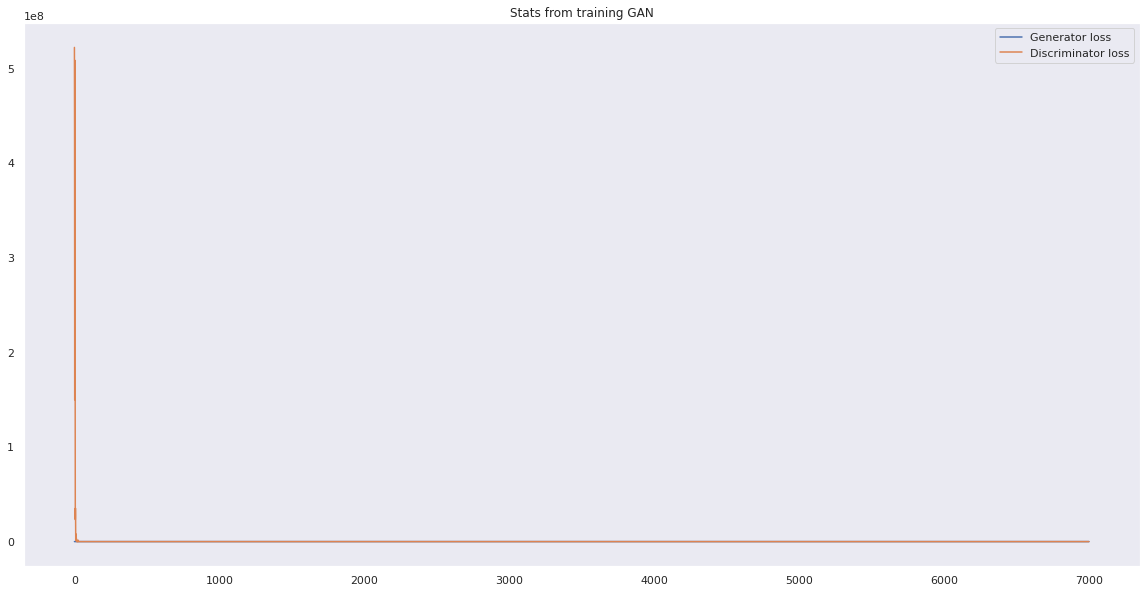

In [28]:
# 자동화로 갠 트레인 가보자잇~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
latent_dim = 3902
gan_train(completegan, generator, discriminator,latent_dim,n_epochs = 7000,n_batch = 63 , n_eval = 200)

In [31]:
# 아래 코드 자동화
def gan_afteone():
  noise = np.random.normal(0, 1, (3902, 3902))
  generated_mixed_data = generator.predict(noise)

  col_name = list(numerical_df.columns) + list(categorical_df.columns)

  globals()['mixed_gen_df'] = pd.DataFrame(data = generated_mixed_data, columns = col_name)


  ######################################## 시각화할거면 넣어~~ ####################################3
  # original_df = pd.DataFrame()
  # for i in globals()['numerical_df'].columns:
  #   original_df = pd.concat([original_df, globals()[f'{i}_numerical']], axis=1)
  # for i in globals()['categorical_df'].columns:
  #   original_df = pd.concat([original_df, globals()[f'{i}_categorical']], axis=1)


  # def normal_distribution(org, noise):  
  #     org_x = np.linspace(org.min(), org.max(), len(org))  
  #     noise_x = np.linspace(noise.min(), noise.max(), len(noise))  
  #     org_y = scipy.stats.norm.pdf(org_x, org.mean(), org.std())  
  #     noise_y = scipy.stats.norm.pdf(noise_x, noise.mean(), noise.std())  
  #     n, bins, patches = plt.hist([org, noise], density = True, alpha = 0.5, color = ["green", "red"])  
  #     xmin, xmax = plt.xlim()  
  #     plt.plot(org_x, org_y, color = "green", label = "Original data", alpha = 0.5)  
  #     plt.plot(noise_x, noise_y, color = "red", label = "Generated data", alpha = 0.5)  
  #     title = f"Original data mean {np.round(org.mean(), 4)}, Original data std {np.round(org.std(), 4)}, Original data var {np.round(org.var(), 4)}\nGenerated data mean {np.round(noise.mean(), 4)}, Generated data {np.round(noise.std(), 4)}, Generated data var {np.round(noise.var(), 2)}"
  #     plt.title(title)  
  #     plt.legend()  
  #     plt.grid()  
  #     plt.show()  
  #     plt.close()

  # Numeric_columns=numerical_df.columns  

  # for column in numerical_df.columns:  
  #     print(column, "Comparison between Original Data and Generated Data")  
  #     normal_distribution(original_df[column], mixed_gen_df[column])

  



In [40]:

def return_gan_data(): # gan_data 뱉어내기(학습용 데이터)
  def binary_step(data):
    # for i in range(len(data)): 
      if data<0.5:
        return 0
      else:
        return 1

  for i in globals()['categorical_df'].columns:
    globals()['mixed_gen_df'][f'{i}'] = globals()['mixed_gen_df'][f'{i}'].apply(binary_step) # 0,1로 다 바꿔주기 
    globals()['mixed_gen_df'][f'{i}'] = globals()['mixed_gen_df'][f'{i}'].astype('int64') # type변환 

  # df_generated_data 생성
  ## numerical_data >> generated_data에 넣어주기 
  df_generated_data = pd.DataFrame()   
  for i in globals()['numerical_df'].columns:
    df_generated_data[f'{i}'] = globals()['mixed_gen_df'][f'{i}']

  ## categorical_data >> generated_data에 넣어주기 
  for i in globals()['categorical_df'].columns:
    df_generated_data[f'{i}'] = globals()['mixed_gen_df'][f'{i}']  
  ## 타겟값 붙여주기 
  df_generated_data['관리종목여부'] = 1
  # 이 다음이 원본데이터에서 모델학습에 쓸 피쳐들 따로 떼서 final_df 만들어주는거 >> 이건 자동화 밖에서 이미 설정해줄거라 포함안시켜도 될 듯 
  
  # 생성된 데이터 X1, y1으로 나뉘어주고 
  y1 = df_generated_data['관리종목여부']
  X1 = df_generated_data.drop(["관리종목여부"], axis=1)


  

  return X1,  y1 # gan을 이용한 증강 데이터 반환(학습용 데이터로 쓸거임.)

In [53]:

y = df['관리종목여부']
X = df[selectioned_flist] # 이거 함수 자동화
gan_afteone()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1123, stratify=y)
gan_X, gan_y = return_gan_data() # 타겟값 1인 데이터 3902개씩 만들기

new_train_X = pd.concat([X_train, gan_X], axis=0)
new_train_X = new_train_X.reset_index(drop=True) # 인덱스 재배열

new_train_y = np.concatenate((y_train, gan_y))



model = CatBoostClassifier(random_state = 1123)
clf = build_model(model, new_train_X, new_train_y)
pred = clf.predict(X_test)


print(f"Precision : {precision_score(y_test, pred, average='macro'):.4f}")
print(f"Recall    : {recall_score(y_test, pred, average='macro'):.4f}")
print(f"F1        : {f1_score(y_test, pred, average='macro'):.4f}")
print(f"Accuracy  : {accuracy_score(y_test, pred):.4f}")


Learning rate set to 0.025027
0:	learn: 0.6298044	total: 5.12ms	remaining: 5.12s
1:	learn: 0.5655739	total: 10.4ms	remaining: 5.2s
2:	learn: 0.5118702	total: 14.6ms	remaining: 4.86s
3:	learn: 0.4610802	total: 20.3ms	remaining: 5.05s
4:	learn: 0.4187256	total: 25.4ms	remaining: 5.06s
5:	learn: 0.3834610	total: 30.8ms	remaining: 5.1s
6:	learn: 0.3462294	total: 36.1ms	remaining: 5.12s
7:	learn: 0.3171114	total: 41.2ms	remaining: 5.11s
8:	learn: 0.2925801	total: 46.5ms	remaining: 5.12s
9:	learn: 0.2683585	total: 51.9ms	remaining: 5.14s
10:	learn: 0.2472702	total: 57.2ms	remaining: 5.14s
11:	learn: 0.2259513	total: 62.8ms	remaining: 5.17s
12:	learn: 0.2053203	total: 67.7ms	remaining: 5.14s
13:	learn: 0.1860681	total: 72.8ms	remaining: 5.13s
14:	learn: 0.1725423	total: 77.2ms	remaining: 5.07s
15:	learn: 0.1616901	total: 82.6ms	remaining: 5.08s
16:	learn: 0.1500439	total: 88ms	remaining: 5.09s
17:	learn: 0.1375077	total: 91.4ms	remaining: 4.99s
18:	learn: 0.1291253	total: 96.8ms	remaining: 5s

## GAN - 모든 모델 & feature selection 성능평가

In [50]:
len(np.concatenate((y_train, gan_y)))

7994

In [43]:
new_train_X

,총자산증가율,자기자본증가율,매출액증가율,총자본영업이익율,자본금순이익율,매출액영업이익율,부채비율,총자본회전율,당기순이익,영업활동으로인한현금흐름,...,부도확률_O_score,K_score,PER,PBR,EPS,DIV,EPS성장률,자본잠식,투자주의환기종목,날짜
0,4.294392,-0.275366,5.803402,-0.083520,0.473480,-0.263848,-0.003666,-0.000063,2.950111e+00,3.994677e+00,...,7.261993,46.493279,-0.107613,1.875961e+01,-8.339979e-03,-0.084842,-0.038391,1,0,0
1,-0.171750,-0.253208,-0.000900,0.410265,3.908581,0.172873,-0.003599,-0.192316,3.067414e+01,2.042002e+00,...,-0.250775,-0.024438,-0.051733,-3.480925e-07,2.292264e+01,-0.188684,17.740112,1,0,1
2,4.253127,2.626538,10.688182,0.069953,-0.001419,2.331036,-0.272320,9.966348,-5.354016e-12,-3.531685e-02,...,-0.082600,1.030879,12.503299,2.628732e+01,-1.340491e-05,9.261973,-0.000788,1,1,1
3,-0.126338,-0.197710,-0.006406,-0.277756,-0.034168,0.637048,25.073645,9.029115,3.464115e+01,-8.573679e-08,...,4.062389,-0.000897,-0.121457,-7.645461e-13,1.578356e+01,0.346332,3.268600,0,0,0
4,7.080138,2.588937,-0.059772,-0.070033,-0.000595,4.599608,-0.017687,9.208189,-3.510186e-18,-7.024690e-10,...,-0.122873,5.400257,19.963234,4.584384e+00,-3.747639e-10,15.878143,-0.000095,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3897,-0.116962,-0.262897,-0.190246,-0.219377,-0.256886,-0.221299,-0.014540,-0.062334,2.048585e+01,-3.740963e-10,...,-0.000064,-0.000396,15.242444,2.601038e+00,-7.845750e-11,13.893846,-0.003988,1,1,1
3898,3.115151,7.280286,-0.030610,0.021179,-0.152022,1.609058,15.317134,25.845125,-4.413828e-03,1.787990e+01,...,-0.001041,-0.000406,4.358077,5.877905e+00,1.174952e+00,0.107854,-0.036766,0,0,0
3899,0.153181,0.226702,25.387644,-0.043254,-0.076571,-0.251626,28.452196,-0.000016,2.443422e+01,-4.440668e-13,...,17.285696,14.571674,-0.049586,2.057804e+01,2.345201e+01,-0.098390,20.120680,1,0,1
3900,-0.129794,-0.156228,24.639502,-0.181053,-0.278458,-0.247349,5.405040,-0.165312,2.760911e+01,2.881771e-01,...,0.437483,-0.001377,-0.144652,2.206965e+01,-3.232395e-03,-0.278323,-0.135050,0,1,1


In [46]:
pd.DataFrame(new_train_y)['관리종목여부'].value_counts()

1    3902
Name: 관리종목여부, dtype: int64

In [34]:
globals()['mixed_gen_df']

,총자산증가율,자기자본증가율,매출액증가율,총자본영업이익율,자본금순이익율,매출액영업이익율,부채비율,총자본회전율,당기순이익,영업활동으로인한현금흐름,...,부도확률_O_score,K_score,PER,PBR,EPS,DIV,EPS성장률,자본잠식,투자주의환기종목,날짜
0,1.191616,-0.106572,-0.058734,-0.273544,6.990669,1.932136,-0.000233,6.771084,-3.515252e-04,1.971719e+01,...,3.259330,-0.000017,4.071073,1.138011e+01,-0.000097,0.023837,-0.059645,1,1,1
1,1.157593,-0.138962,16.360094,-0.266850,-0.136444,-0.273020,18.422695,-0.001699,1.430632e+01,2.496082e+00,...,5.136586,37.084904,-0.041160,2.982739e+01,0.546910,-0.041589,-0.020505,1,0,0
2,-0.241893,-0.240664,-0.071394,-0.198118,1.272500,-0.236800,-0.070194,-0.001399,7.399914e+00,1.522813e+01,...,-0.193933,-0.005125,-0.064430,-3.842403e-09,21.059797,-0.269259,15.371991,1,0,1
3,4.671328,6.177663,4.932880,2.459533,-0.006198,1.015908,-0.263360,14.592232,-1.220703e-09,4.906755e+00,...,-0.040278,-0.144048,9.094188,2.944125e+01,-0.000048,7.164945,-0.000877,1,1,1
4,2.643160,-0.038278,14.817264,-0.098897,-0.004384,-0.168785,17.275713,-0.000049,8.238906e+00,-1.842801e-16,...,19.970182,55.397587,-0.207522,2.019761e+01,-0.002681,1.215731,-0.013384,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3897,1.738790,6.039080,-0.030387,0.882867,-0.191313,0.966085,18.633343,37.681194,1.174889e+01,1.806471e+01,...,-0.013691,-0.000134,3.895184,-4.414603e-05,-0.206452,1.313224,-0.108228,0,0,0
3898,-0.214838,-0.275175,-0.066738,-0.269475,2.464359,-0.049726,-0.093111,14.919179,-1.750205e-02,1.958957e+01,...,-0.020397,-0.276205,-0.226672,2.176431e+01,-0.039995,-0.080376,-0.031065,1,0,0
3899,2.126491,-0.151477,14.570222,-0.222746,-0.251656,0.086472,-0.272504,-0.000152,-3.893807e-04,1.946489e+01,...,-0.086237,-0.026070,-0.032654,1.602353e+01,22.365168,-0.128645,16.490864,1,0,0
3900,-0.272895,-0.276858,-0.083474,-0.276176,-0.253078,-0.251481,-0.265507,-0.002467,2.746721e+01,-6.740247e-03,...,0.584951,2.383470,-0.118002,3.707573e+01,8.881025,-0.164620,-0.276713,0,0,0


In [35]:
X_train

,총자산증가율,자기자본증가율,매출액증가율,총자본영업이익율,자본금순이익율,매출액영업이익율,부채비율,총자본회전율,당기순이익,영업활동으로인한현금흐름,...,부도확률_O_score,K_score,자본잠식,투자주의환기종목,날짜,PER,PBR,EPS,DIV,EPS성장률
3946,51.08,-33.46,-48.06,-15.80,-220.25,-2804.73,144.75,0.01,-1.479115e+10,-6.040461e+09,...,0.004008,-6.172493,0,0,2021,33.855,7.06,-1099.0,0.000000,-3.303983
3704,19.68,5.23,6.36,5.30,29.90,3.40,55.56,1.56,2.129262e+09,6.450040e+08,...,0.000314,27.000318,0,0,2020,25.600,1.60,142.0,2.340000,-0.759729
1542,69.71,129.13,1.76,3.56,-292.00,3.73,23.56,0.96,-1.180134e+10,2.859824e+09,...,0.010310,11.189354,0,0,2019,173.750,1.07,12.0,0.000000,11.000000
457,-4.66,-5.13,-11.62,-8.25,-34.91,-16.57,15.73,0.50,-2.363712e+09,1.197800e+07,...,0.000395,17.898521,1,0,2018,41.360,0.69,-175.0,0.000000,-0.356618
436,11.58,12.29,-10.23,0.92,204.48,1.73,50.42,0.53,1.542668e+10,1.486036e+10,...,0.000232,26.653633,0,0,2018,12.500,1.54,904.0,0.620000,4.255814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1661,-4.10,3.75,-6.26,3.94,52.53,3.88,20.08,1.02,5.546171e+09,1.594917e+10,...,0.000031,29.507920,0,0,2019,10.650,0.62,269.0,2.440000,-0.574367
1177,12.72,-3.83,-63.85,-4.55,-122.59,-10.98,117.47,0.41,-7.296394e+09,-1.397714e+10,...,0.004177,20.000407,0,0,2018,14.960,6.59,779.0,0.210000,0.000000
4957,-7.83,21.75,20.71,-11.89,-38.39,-108.37,8.14,0.11,-2.555557e+09,-4.958079e+09,...,0.000064,2.964376,0,0,2021,17.870,-178.00,0.0,-0.897169,-5.930419
999,0.04,-5.18,-18.77,-1.64,-40.13,-2.55,26.72,0.64,-2.795032e+09,1.114896e+10,...,0.000297,28.585600,0,0,2018,75.240,0.81,62.0,1.290000,-0.578231


In [36]:
new_train_X

,총자산증가율,자기자본증가율,매출액증가율,총자본영업이익율,자본금순이익율,매출액영업이익율,부채비율,총자본회전율,당기순이익,영업활동으로인한현금흐름,...,부도확률_O_score,K_score,자본잠식,투자주의환기종목,날짜,PER,PBR,EPS,DIV,EPS성장률
0,51.08,-33.46,-48.06,-15.80,-220.25,-2804.73,144.75,0.01,-1.479115e+10,-6.040461e+09,...,0.004008,-6.172493,0,0,2021,33.855,7.06,-1099.0,0.000000,-3.303983
1,19.68,5.23,6.36,5.30,29.90,3.40,55.56,1.56,2.129262e+09,6.450040e+08,...,0.000314,27.000318,0,0,2020,25.600,1.60,142.0,2.340000,-0.759729
2,69.71,129.13,1.76,3.56,-292.00,3.73,23.56,0.96,-1.180134e+10,2.859824e+09,...,0.010310,11.189354,0,0,2019,173.750,1.07,12.0,0.000000,11.000000
3,-4.66,-5.13,-11.62,-8.25,-34.91,-16.57,15.73,0.50,-2.363712e+09,1.197800e+07,...,0.000395,17.898521,1,0,2018,41.360,0.69,-175.0,0.000000,-0.356618
4,11.58,12.29,-10.23,0.92,204.48,1.73,50.42,0.53,1.542668e+10,1.486036e+10,...,0.000232,26.653633,0,0,2018,12.500,1.54,904.0,0.620000,4.255814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4087,-4.10,3.75,-6.26,3.94,52.53,3.88,20.08,1.02,5.546171e+09,1.594917e+10,...,0.000031,29.507920,0,0,2019,10.650,0.62,269.0,2.440000,-0.574367
4088,12.72,-3.83,-63.85,-4.55,-122.59,-10.98,117.47,0.41,-7.296394e+09,-1.397714e+10,...,0.004177,20.000407,0,0,2018,14.960,6.59,779.0,0.210000,0.000000
4089,-7.83,21.75,20.71,-11.89,-38.39,-108.37,8.14,0.11,-2.555557e+09,-4.958079e+09,...,0.000064,2.964376,0,0,2021,17.870,-178.00,0.0,-0.897169,-5.930419
4090,0.04,-5.18,-18.77,-1.64,-40.13,-2.55,26.72,0.64,-2.795032e+09,1.114896e+10,...,0.000297,28.585600,0,0,2018,75.240,0.81,62.0,1.290000,-0.578231


In [39]:
pd.DataFrame(new_train_y)['관리종목여부'].value_counts()

0    3999
1    3995
Name: 관리종목여부, dtype: int64

0       0
1       0
2       0
3       0
4       0
       ..
7989    1
7990    1
7991    1
7992    1
7993    1
Name: 관리종목여부, Length: 7994, dtype: int64

In [ ]:
# noise = np.random.normal(0, 1, (3902, 3902))  
# generated_mixed_data = generator.predict(noise)  
# columns=list(EPS성장률_numerical.columns)+list(PBR_numerical.columns)+list(K_score_numerical.columns) +list(총자본영업이익율_numerical.columns)+list(매출액증가율_numerical.columns) +list(총자산증가율_numerical.columns)+list(총자본순이익율_numerical.columns)+list(자본잠식_categorical.columns)+list(투자주의환기종목_categorical.columns)+list(부실기업판별_K_score_categorical.columns)+list(관리종목요건_매출액_categorical.columns)+list(소송_categorical.columns)  +list(벌금_categorical.columns)
# #  +list(K_score_numerical.columns)+list(부실여부판단_K_numerical.columns)+list(성장성_numerical.columns)+list(수익성_numerical.columns)+list(안정성_numerical.columns)+list(활동성_numerical.columns)+list(현금흐름_numerical.columns)+list(불성실공시_numerical.columns)+list(벌금_numerical.columns)+list(소송_numerical.columns)+list(영업정지_numerical.columns)+list(특허_numerical.columns)+list(자본잠식_numerical.columns)+list(투자주의환기종목_numerical.columns)+list(업종_numerical.columns)

# mixed_gen_df = pd.DataFrame(data = generated_mixed_data, columns = columns)  
# # mixed_gen_df.iloc[:,:-3] = np.round(mixed_gen_df.iloc[:,:-3])  
# # mixed_gen_df.iloc[:,-3:] = scaling.inverse_transform(mixed_gen_df.iloc[:,-3:])  

# #Original Data
# original_df = pd.concat([EPS성장률_numerical,PBR_numerical,K_score_numerical
#                        ,총자본영업이익율_numerical,매출액증가율_numerical,총자산증가율_numerical,총자본순이익율_numerical
#                        ,자본잠식_categorical,투자주의환기종목_categorical
#                          ,부실기업판별_K_score_categorical,관리종목요건_매출액_categorical
#                         ,소송_categorical ,벌금_categorical
#                         #  ,
#                         #  K_score_numerical, 부실여부판단_K_numerical, 성장성_numerical, 수익성_numerical, 안정성_numerical,
#                         #  활동성_numerical,현금흐름_numerical,  불성실공시_numerical ,벌금_numerical , 소송_numerical, 영업정지_numerical,특허_numerical, 자본잠식_numerical,
#                         # 투자주의환기종목_numerical,업종_numerical
#                          ], axis = 1)  
# def normal_distribution(org, noise):  
#     org_x = np.linspace(org.min(), org.max(), len(org))  
#     noise_x = np.linspace(noise.min(), noise.max(), len(noise))  
#     org_y = scipy.stats.norm.pdf(org_x, org.mean(), org.std())  
#     noise_y = scipy.stats.norm.pdf(noise_x, noise.mean(), noise.std())  
#     n, bins, patches = plt.hist([org, noise], density = True, alpha = 0.5, color = ["green", "red"])  
#     xmin, xmax = plt.xlim()  
#     plt.plot(org_x, org_y, color = "green", label = "Original data", alpha = 0.5)  
#     plt.plot(noise_x, noise_y, color = "red", label = "Generated data", alpha = 0.5)  
#     title = f"Original data mean {np.round(org.mean(), 4)}, Original data std {np.round(org.std(), 4)}, Original data var {np.round(org.var(), 4)}\nGenerated data mean {np.round(noise.mean(), 4)}, Generated data {np.round(noise.std(), 4)}, Generated data var {np.round(noise.var(), 2)}"
#     plt.title(title)  
#     plt.legend()  
#     plt.grid()  
#     plt.show()  

# Numeric_columns=numerical_df.columns  

# for column in numerical_df.columns:  
#     print(column, "Comparison between Original Data and Generated Data")  
#     normal_distribution(original_df[column], mixed_gen_df[column])

# # for column in categorical_df.columns:  
# #   print(column, "Comparison between Original Data and Generated Data")  
# #   normal_distribution(original_df[column], mixed_gen_df[column])

In [ ]:
# 날짜 꼭 드롭하고 갠 돌리기

# 보영이 코드


In [ ]:
def gan_train(gan, generator, discriminator, catsh1,catsh2,catsh3,catsh4,catsh5,catsh6,catsh7,catsh8,catsh9,catsh10,catsh11,catsh12, catsh13, catsh14, catsh15, catsh16, catsh17, catsh18, catsh19, catsh20,catsh21, latent_dim, n_epochs, n_batch,n_eval):  # ,numerical
#, catsh22,catsh23, catsh24, catsh25, catsh26, catsh27,catsh28 , 
    half_batch = int(n_batch / 2)  
    discriminator_loss = []  
    generator_loss = []  
    valid = np.ones((half_batch, 1))  
    y_gan = np.ones((n_batch,1))   #, 1  
    # noise = np.random.normal(0, 1, size=[batch_size, random_dim])
    # y_gen = np.ones(batch_size)
    fake = np.zeros((half_batch, 1))  
    n_epochs = 7000 # 수정하렴! 

    for i in range(n_epochs):  
      idx = np.random.randint(0, catsh1.shape[0], half_batch)      

      총자산증가율_real = catsh1[idx]  
      자기자본증가율_real = catsh2[idx]  
      매출액증가율_real = catsh3[idx]  
      총자본영업이익율_real = catsh4[idx]  
      자본금순이익율_real = catsh5[idx]  
      매출액영업이익율_real = catsh6[idx]  
      부채비율_real = catsh7[idx]  
      총자본회전율_real = catsh8[idx]  
      당기순이익_real = catsh9[idx]  
      영업활동으로인한현금흐름_real = catsh10[idx]  
      Z_score_real = catsh11[idx]  
      부도확률_O_score = catsh12[idx]  
      K_score_real = catsh13[idx]  
      자본잠식_real = catsh14[idx]  
      투자주의환기종목_real = catsh15[idx]  
      날짜_real = catsh16[idx]  
      PER_real = catsh17[idx]  
      PBR_real = catsh18[idx]  
      EPS_real = catsh19[idx]  
      DIV_real = catsh20[idx]  
      EPS성장률_real = catsh21[idx]   
      # 벌금_real = catsh22[idx]  
      # 소송_real = catsh23[idx]    
      # 영업정지_real = catsh24[idx]          
      # 특허_real = catsh25[idx]          
      # 자본잠식_real = catsh26[idx]          
      # 투자주의환기종목_real = catsh27[idx]          
      # 업종_real = catsh28[idx]          
      # numerical_real = numerical[idx]

      real_data = np.concatenate([총자산증가율_real, 자기자본증가율_real, 매출액증가율_real ,총자본영업이익율_real,자본금순이익율_real,
                                  매출액영업이익율_real,부채비율_real ,총자본회전율_real, 당기순이익_real,영업활동으로인한현금흐름_real,
                                  Z_score_real,부도확률_O_score , K_score_real,자본잠식_real,  투자주의환기종목_real,
                                  날짜_real , PER_real , PBR_real, EPS_real, DIV_real,
                                  EPS성장률_real
                                  # ,소송_real , 영업정지_real, 특허_real,자본잠식_real, 투자주의환기종목_real,업종_real
                                  # ,numerical_real
                                  ], axis = 1)  


      noise = np.random.normal(0, 1, (half_batch, latent_dim))  
      fake_data = generator.predict(noise)  
    
      d_loss_real =  da_real = discriminator.train_on_batch(real_data, valid)  # 요기 수수께끼 
      d_loss_fake = da_fake = discriminator.train_on_batch(fake_data, fake)   # 요기 수수께끼 
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)   # 요기 수수께끼 
      discriminator_loss.append(d_loss)    # 요기 수수께끼  
      
      noise = np.random.normal(0, 1, (n_batch, latent_dim))  
      g_loss = gan.train_on_batch(noise, y_gan)  
      generator_loss.append(g_loss)  

      #evaluate progress
      if (i+1) % n_eval == 0:  
          print ("Epoch: %d [Discriminator loss: %f] [Generator loss: %f]" % (i + 1, d_loss, g_loss ))  
            
    plt.figure(figsize = (20, 10))  
    plt.plot(generator_loss, label = "Generator loss")  
    plt.plot(discriminator_loss, label = "Discriminator loss")     
    plt.title("Stats from training GAN")  
    plt.grid()  
    plt.legend()  

In [ ]:
latent_dim = 5000
gan_train(completegan, generator, discriminator,
          총자산증가율_numerical.values, 자기자본증가율_numerical.values, 매출액증가율_numerical.values , 총자본영업이익율_numerical.values,자본금순이익율_numerical.values,
          매출액영업이익율_numerical.values,부채비율_numerical.values,총자본회전율_numerical.values,당기순이익_numerical.values,영업활동으로인한현금흐름_numerical.values, 
          Z_score_numerical.values,부도확률_O_score_numerical.values,K_score_numerical.values,PER_numerical.values,PBR_numerical.values, 
          EPS_numerical.values,DIV_numerical.values,EPS성장률_numerical.values , 자본잠식_categorical.values , 투자주의환기종목_categorical.values , 날짜_categorical.values,
          latent_dim,
          n_epochs = 7000,
          n_batch = 63
          , n_eval = 200
          )

Epoch: 200 [Discriminator loss: 3.848173] [Generator loss: 0.007541]
Epoch: 400 [Discriminator loss: 4.182207] [Generator loss: 0.002163]
Epoch: 600 [Discriminator loss: 4.654871] [Generator loss: 0.001467]
Epoch: 800 [Discriminator loss: 5.449345] [Generator loss: 0.000914]
Epoch: 1000 [Discriminator loss: 5.632018] [Generator loss: 0.001010]


KeyboardInterrupt: ignored